<a href="https://colab.research.google.com/github/dzkha/DS-Unit-2-Classification-1/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [4]:
pd.set_option('display.max_rows', 500)
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,GSW,HOU,Regular Season,4.0
2009-10-28,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,GSW,HOU,Regular Season,-9.0
2009-10-28,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,GSW,HOU,Regular Season,-6.0
2009-10-28,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,GSW,HOU,Regular Season,-9.0


In [0]:
df['homecourt_advantage'] = 0

df['homecourt_advantage']= df['htm'].map({'GSW':1})
df.fillna({'homecourt_advantage':0,},inplace=True)



In [0]:
df['made_prev_shot'] = df['shot_made_flag'].shift(1)
df.fillna({'made_prev_shot':0,},inplace=True)

In [0]:
df['seconds_left_period'] = (60*df['minutes_remaining']) + df['seconds_remaining']

In [0]:
df['seconds_left_game'] = (720*(4 - df['period'])) + df['seconds_left_period']

In [0]:
df['opponent'] = df['vtm']

In [0]:
def replacer(htm,vtm):
  if htm == "GSW":
    return vtm
  else:
    return htm

In [0]:
opp = [replacer(x,y) for x, y in zip(df['htm'], df['vtm'])]

In [0]:
df['opponent'] = opp

In [107]:
df.isna().values.any()

False

In [96]:
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,made_prev_shot,seconds_left_period,seconds_left_game,opponent
game_date,,,,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.00,1.00,0.00,685,2845,HOU
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.00,1.00,0.00,571,2731,HOU
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.00,1.00,1.00,362,2522,HOU
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.00,1.00,0.00,589,2029,HOU
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.00,1.00,0.00,139,1579,HOU
2009-10-28,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,GSW,HOU,Regular Season,4.00,1.00,0.00,34,1474,HOU
2009-10-28,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,GSW,HOU,Regular Season,-9.00,1.00,0.00,626,626,HOU
2009-10-28,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,GSW,HOU,Regular Season,-6.00,1.00,1.00,391,391,HOU
2009-10-28,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,GSW,HOU,Regular Season,-9.00,1.00,1.00,145,145,HOU


In [97]:
train = df['2009':'2017-07']
val = df['2017-08':'2018-07']
test = df['2018-08':]

print(train.shape,val.shape,test.shape)

train.head()


(11081, 24) (1168, 24) (1709, 24)


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,made_prev_shot,seconds_left_period,seconds_left_game,opponent
game_date,,,,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.00,1.00,0.00,685,2845,HOU
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.00,1.00,0.00,571,2731,HOU
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.00,1.00,1.00,362,2522,HOU
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.00,1.00,0.00,589,2029,HOU
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.00,1.00,0.00,139,1579,HOU


In [70]:
test.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,made_prev_shot,seconds_left_period,seconds_left_game,opponent
game_date,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-16,21800002,10,Stephen Curry,1,11,31,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,226,90,1,GSW,OKC,Regular Season,0.00,1.00,0.00,691,2851,OKC
2018-10-16,21800002,58,Stephen Curry,1,7,57,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-2,63,1,GSW,OKC,Regular Season,4.00,1.00,1.00,477,2637,OKC
2018-10-16,21800002,131,Stephen Curry,1,3,46,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,5,29,1,GSW,OKC,Regular Season,4.00,1.00,1.00,226,2386,OKC
2018-10-16,21800002,141,Stephen Curry,1,2,58,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-6,18,0,GSW,OKC,Regular Season,7.00,1.00,1.00,178,2338,OKC
2018-10-16,21800002,145,Stephen Curry,1,2,49,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-228,8,1,GSW,OKC,Regular Season,7.00,1.00,0.00,169,2329,OKC


In [14]:
train['shot_made_flag'].value_counts()

0    5842
1    5239
Name: shot_made_flag, dtype: int64

In [15]:
val['shot_made_flag'].value_counts()

0    603
1    565
Name: shot_made_flag, dtype: int64

In [16]:
print("Baseline accuracy:",603/(603 + 565))

Baseline accuracy: 0.5162671232876712


In [17]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.4MB/s 


In [161]:
%%time
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
pd.set_option('display.float_format', '{:.2f}'.format)

target = 'shot_made_flag'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality.index.tolist()
features = numeric_features + categorical_features


X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# pipeline = make_pipeline(
#     ce.OrdinalEncoder(),
#     RandomForestClassifier(n_estimators=1000, random_state=55, n_jobs=-1))

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(n_estimators=1000, random_state=55, n_jobs=-1))

# pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     RobustScaler(),
#     LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000))


# pipeline = make_pipeline(
#     ce.OrdinalEncoder(),
#     RobustScaler(),
#     LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000))





pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.598458904109589
CPU times: user 38.7 s, sys: 640 ms, total: 39.3 s
Wall time: 20.7 s


In [162]:
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.6290228203627852


In [119]:
pipeline.steps[2][1]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
one_hot_features = X_train_encoded.columns

In [143]:
coefficients = pipeline.steps[2][1].coef_
coefficients[0]

array([ 0.01565269,  0.0173107 , -0.02488044,  0.0517289 ,  0.04857253,
       -0.96655589, -0.03084853, -0.04424867, -0.00791357,  0.18279569,
       -0.00155745,  0.04217505,  0.01437061,  0.        , -0.05163059,
        0.27832052, -0.07288776, -0.9251084 ,  0.05983897, -0.03042353,
       -0.85573576,  0.02782779])

In [0]:
importances = pipeline.steps[1][1].feature_importances_

Text(0.5, 1.0, 'Feature Coefficients for Logistic Regression with Ordinal Encoding')

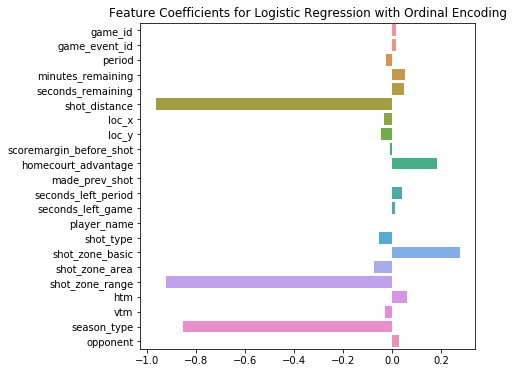

In [145]:

fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(coefficients[0],features,orient='h')
plt.title("Feature Coefficients for Logistic Regression with Ordinal Encoding")

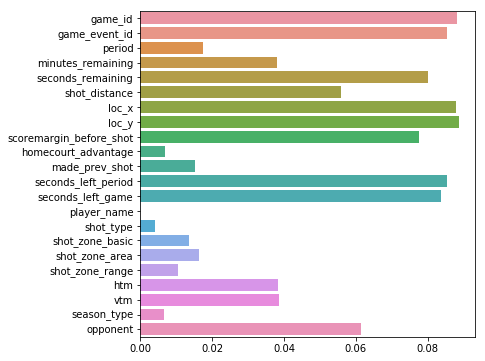

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(importances,features,orient='h')
plt.title("Feature Importances for Random Forest with Ordinal Encoding")

In [172]:
len(one_hot_features)

131

ValueError: ignored

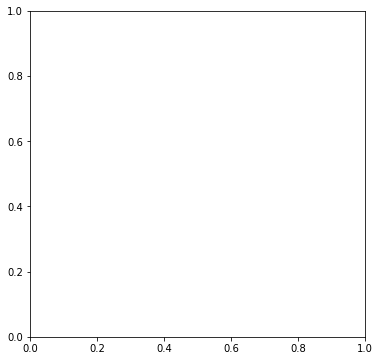

In [168]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(importances,one_hot_features,orient='h')
plt.title("Feature Importances for Random Forest with One Hot Encoding")

Text(0.5, 1.0, 'Feature Importances for Logistic Regression with One Hot Encoding')

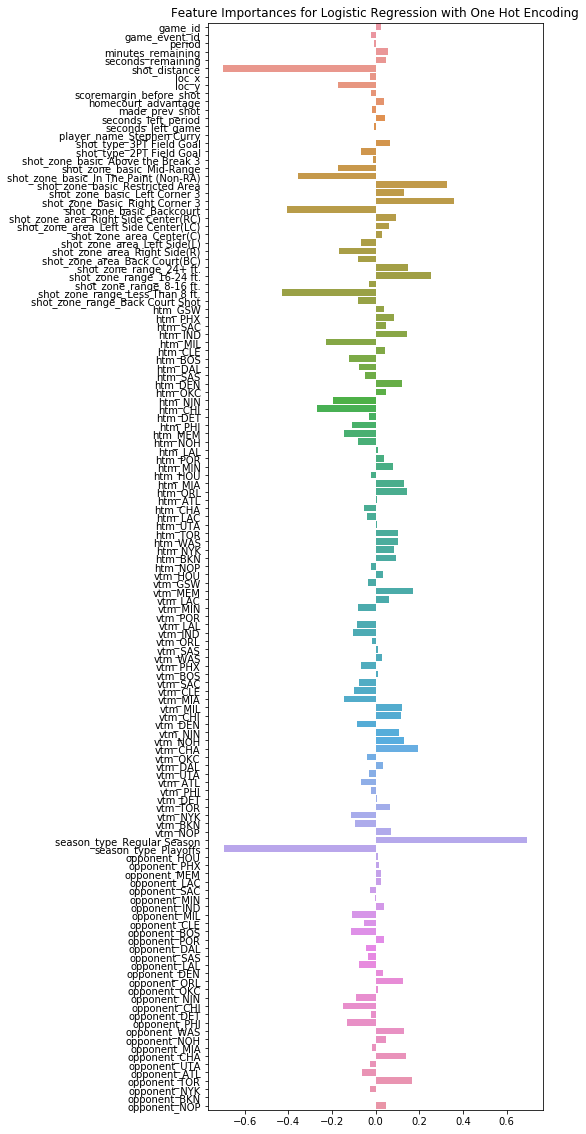

In [132]:
fig, ax = plt.subplots(figsize=(6,20))
sns.barplot(coefficients[0],one_hot_features,orient='h')
plt.title("Feature Importances for Logistic Regression with One Hot Encoding")

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [76]:
#Provided confusion matrix
TP = 36
TN = 85
FP = 58
FN = 8


precision = TP/(TP+FP)
recall = TP/(TP+FN)
f_score = 2*(precision*recall)/(precision+recall)

print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))
print("Precision:",precision)
print("Recall:",recall)
print("F1 Score:",f_score)

Accuracy: 0.6470588235294118
Precision: 0.3829787234042553
Recall: 0.8181818181818182
F1 Score: 0.5217391304347826


In [163]:
y_pred = pipeline.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

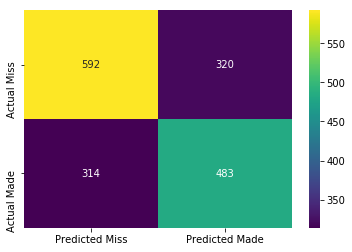

In [164]:
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_test, y_pred):
    labels = ['Miss','Made']
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
    
plot_confusion_matrix(y_test, y_pred);

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       912
           1       0.60      0.61      0.60       797

    accuracy                           0.63      1709
   macro avg       0.63      0.63      0.63      1709
weighted avg       0.63      0.63      0.63      1709

